# Dataset for Segmentation

In this notebook we explore the dataset that will be used to train, validate and test the segmentation model.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [ ]:
import sys
import os
import yaml
import argparse

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Save program's directory
cwd = os.getcwd()
if cwd == '/content':  # If we are in colab, we mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change dir to where project is located
    os.chdir("drive/MyDrive/CoVision/segmentation")
    cwd = os.getcwd()
elif 'drive' in cwd:  # Already monted and changed dir
    pass
elif 'notebooks_seg' in os.listdir(cwd):  # Local machine case
    cwd = './'
else:  # If currently in notebook folder
    os.chdir('./..')
    cwd = './'
print(f'Current working directory: {cwd}\n')

# Read arguments from dict and store them as Namespace
with open(cwd + 'config_seg.yaml', 'r') as f:
    args = argparse.Namespace(**yaml.safe_load(f))

data_args = argparse.Namespace(**args.data_args)
transformation_args = argparse.Namespace(**args.transformation_args)
evaluation_args = argparse.Namespace(**args.evaluation_args)

# Add source folder to PYTHONPATH
sys.path.insert(0, 'src_seg/')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: ./



## Raw data

The raw (and minimal required) form of data comes divided in the `{kit_id}_images` and `{kit_id}_masks` folders containing, respectively, images (.jpg) and their corresponding human-anotated masks (.png). The latter contains the background in blue, kit in red and membrane in green.

In [ ]:
kit_id = 'aconag'
kit_folder = os.path.join(data_args.data_dir, kit_id)
images_folder = os.path.join(kit_folder, f'{kit_id}_images')
masks_folder = os.path.join(kit_folder, f'{kit_id}_masks')

image_paths = sorted([os.path.join(images_folder, img) for img in os.listdir(images_folder)])
masks_paths = sorted([os.path.join(masks_folder, masks) for masks in os.listdir(masks_folder)])

print(f'Number of images: {len(image_paths)}')
print(f'First image path: {image_paths[0]}')

print(f'Number of masks: {len(masks_paths)}')
print(f'First mask path: {masks_paths[0]}')

Number of images: 40
First image path: data_seg/aconag/aconag_images/IMG_0254.jpg
Number of masks: 40
First mask path: data_seg/aconag/aconag_masks/IMG_0254.png


Types (img, mask): <class 'numpy.ndarray'>, <class 'numpy.ndarray'>
Shapes (img, mask): (4032, 3024, 3), (4032, 3024, 3)
Max-Min values (img, mask): (255, 0), (255, 0)


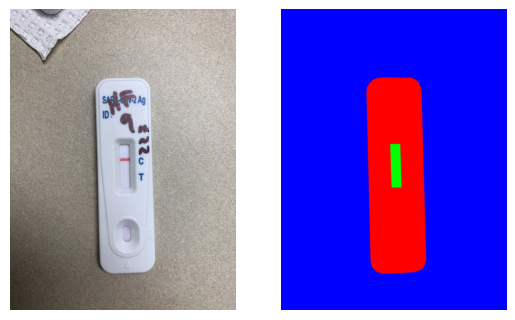

In [ ]:
# Read image and mask
image_raw = cv2.imread(image_paths[0])
masks_raw = cv2.imread(masks_paths[0])
print(f'Types (img, mask): {type(image_raw)}, {type(masks_raw)}')
print(f'Shapes (img, mask): {image_raw.shape}, {masks_raw.shape}')
print(f'Max-Min values (img, mask): ({image_raw.max()}, {image_raw.min()}), ({masks_raw.max()}, {masks_raw.min()})')

# Display
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_raw[:,:,::-1])
ax1.axis('off')
ax2.imshow(masks_raw[:,:,::-1])
ax2.axis('off')
plt.show()

## Data split

The raw data must be split into train, validation, and test sets. In order to do so we use the custom function `split_data`.

In [ ]:
from preprocessing_seg import split_data

In [ ]:
split_data(data_args, kit_id)

File data_seg/aconag/aconag_filenames.csv already exists! Do you want to overwrite it? (y/n): n


SystemExit: The file was not overwritten :)

/home/guybrush/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
filenames_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_filenames.csv'), index_col=0)
print(filenames_df.value_counts('data_mode'))
filenames_df.head(10)

data_mode
train    25
test      8
val       7
dtype: int64


data_mode
IMG_0257                                     train
IMG_1360                                     train
IMG_0262                                     train
IMG_1506                                       val
IMG_1373                                       val
SH00065_deb5c0f8ed7b4523a384125b635ce730     train
IMG_1048                                     train
IMG_1392                                       val
IMG_1555                                     train
IMG_1575                                       val

## Dataset

We can use the `LFASegmentationDataset` class to create our custom Pytorch's dataset.

In [ ]:
from dataset_seg import LFASegmentationDataset

In [ ]:
kit_id = ['aconag', 'deepblueag', 'paramountag']
shots_train = [None]*len(kit_id)
shots_eval = [None]*len(kit_id)
dataset_train = LFASegmentationDataset(args=data_args, kit_id=kit_id, data_mode='train', shots=shots_train, transforms=None)
dataset_val = LFASegmentationDataset(args=data_args, kit_id=kit_id, data_mode='val', shots=shots_eval, transforms=None)
dataset_test = LFASegmentationDataset(args=data_args, kit_id=kit_id, data_mode='test', shots=shots_eval, transforms=None)

Loaded 77 image and mask paths for aconag-deepblueag-paramountag kit(s) in train data mode
Loaded 21 image and mask paths for aconag-deepblueag-paramountag kit(s) in val data mode
Loaded 25 image and mask paths for aconag-deepblueag-paramountag kit(s) in test data mode


The dataset elements can be accessed via the custom `__getitem__` method. Each element is a tuple of the form (image, target). The former corresponds to the raw, resized image while target is a dictionary containg target variables (ground truths), as they are required for training the segmentation model. They are built from each human-annotated mask using the method `build_target_from_mask()`. For each RGB mask, this function returns a dictionary containing the class category masks (one-hot-encoding), bounding boxes, and labels, all in numpy array format. Both image and target variables are always converted to torch Tensors. If a custom transformation is passed in the `transformation` option during initialization, the output elements are not the raw ones, but the output of those transformations.

In [ ]:
image, target = dataset_train[0]
print(f'Image type, shape and max-min values: {type(image)}, {image.shape}, {image.max()}, {image.min()}')
print(target)

Image type, shape and max-min values: <class 'torch.Tensor'>, torch.Size([3, 800, 600]), 1.0, 0.0
{'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'boxes': tensor([[235., 136., 393., 693.],
        [299., 323., 326., 448.]]), 'labels': tensor([1, 2])}


### DataLoaders

Finally, these dataset are uses to generate the corresponding DataLoaders, which randomly generate batches of (image, target) pairs to use during training and validation. The format in which these batches are retrieved is dictated by the custom `collate_fn` method.

In [ ]:
from dataloader_seg import init_dataloader

In [ ]:
loader_train = init_dataloader(data_args, kit_id, 'train',
                               n_batches=4, n_workers=0, shuffle=True, shots=shots_train, transform=None)
loader_val = init_dataloader(data_args, kit_id, 'val',
                               n_batches=4, n_workers=0, shuffle=False, shots=shots_eval, transform=None)

Loaded 77 image and mask paths for aconag-deepblueag-paramountag kit(s) in train data mode
Loaded 21 image and mask paths for aconag-deepblueag-paramountag kit(s) in val data mode


In [ ]:
batch = next(iter(loader_train))
print(f'Length batch: {len(batch[0])}')

images, targets = batch[0], batch[1]
image, target = images[0], targets[0]
print(f'Image type, shape and max-min values: {type(image)}, {image.shape}, {image.max()}, {image.min()}')
print(target)

Length batch: 4
Image type, shape and max-min values: <class 'torch.Tensor'>, torch.Size([3, 800, 600]), 1.0, 0.0
{'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'boxes': tensor([[186., 207., 372., 697.],
        [254., 366., 291., 474.]]), 'labels': tensor([1, 2])}


### Visualization

We can visualize images, their masks and bounding boxes using the `show_image` function

In [ ]:
from utils_seg.visualization import show_images

In [ ]:
show_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

### Transformations

For data augmentation we will use the `albumentation` package. The nice thing about this package is that it can be used in pairs of (image, mask), so the same transformation is done on both simultaneously.

In [ ]:
import albumentations as A

In [ ]:
# Read a single pair of image and mask to show the effect of different transformations
kit_id = 'aconag'

images_folder = os.path.join(data_args.data_dir, kit_id, f'{kit_id}_images')
masks_folder = os.path.join(data_args.data_dir, kit_id, f'{kit_id}_masks')

image_paths = sorted([os.path.join(images_folder, img) for img in os.listdir(images_folder)])
masks_paths = sorted([os.path.join(masks_folder, masks) for masks in os.listdir(masks_folder)])

image = cv2.imread(image_paths[0])
mask = cv2.imread(masks_paths[0])

(4032, 3024, 3) (4032, 3024, 3)


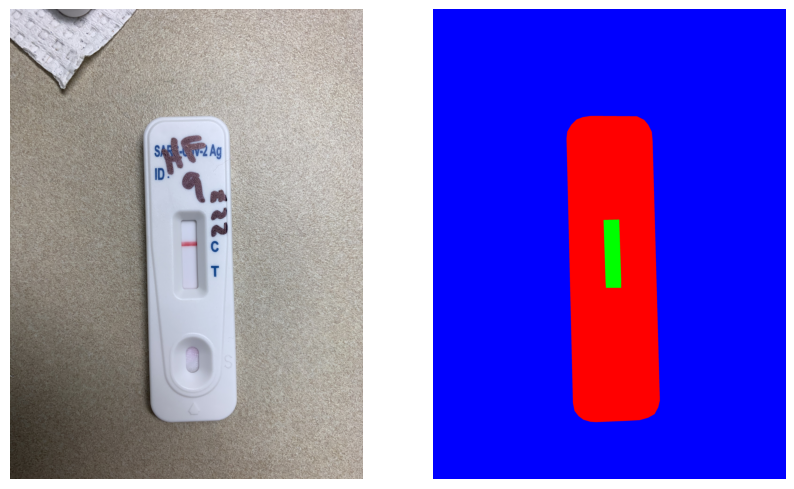

In [ ]:
# Original image and mask
print(image.shape, mask.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask[:,:,::-1])
ax2.axis('off')
plt.show()

Since displaying large images can be time consuming, we resize them prior to any other data augmentation trasnformation. We do this by using our custom `resize_image` function

In [ ]:
from transformations_seg import resize_image

In [ ]:
image = resize_image(image, data_args.resize_height)
mask = resize_image(mask, data_args.resize_height)
print(image.shape, mask.shape)

(800, 600, 3) (800, 600, 3)


We now explore the effect of different data augmentation transformations

#### Rotation

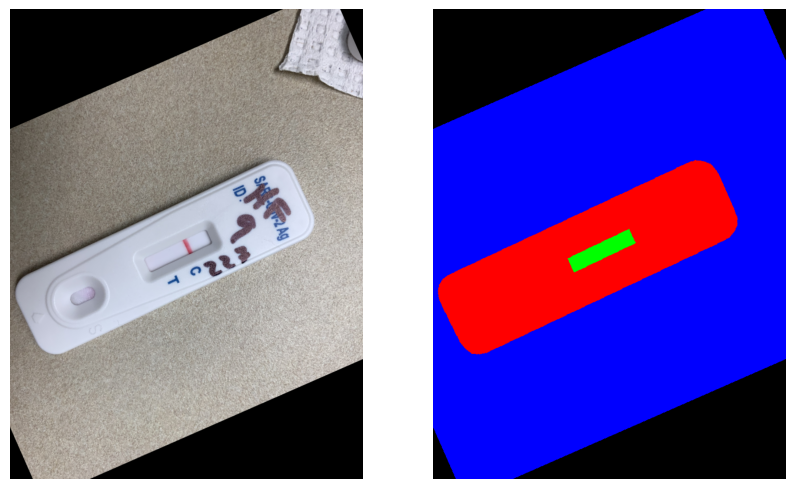

In [ ]:
rotate = A.Rotate(limit=transformation_args.rotate_limit, p=1.0, border_mode=cv2.BORDER_CONSTANT)
transformation_dict = rotate(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Horizontal flip

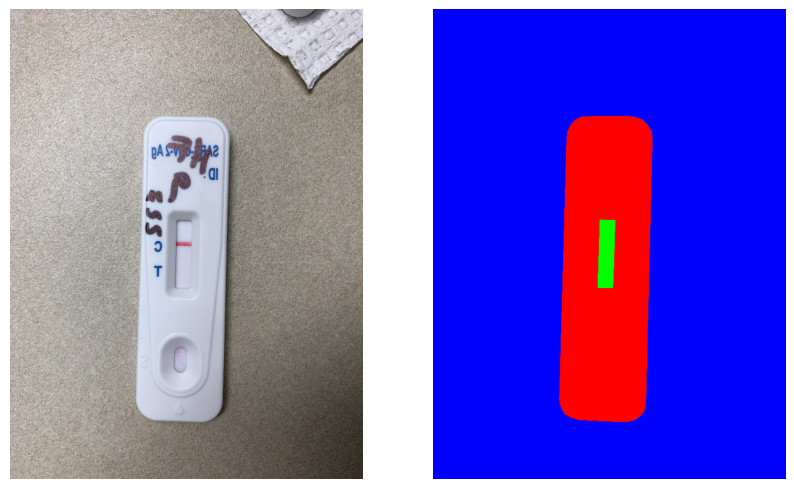

In [ ]:
horizontal_flip = A.HorizontalFlip(p=1.0)
transformation_dict = horizontal_flip(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Blur

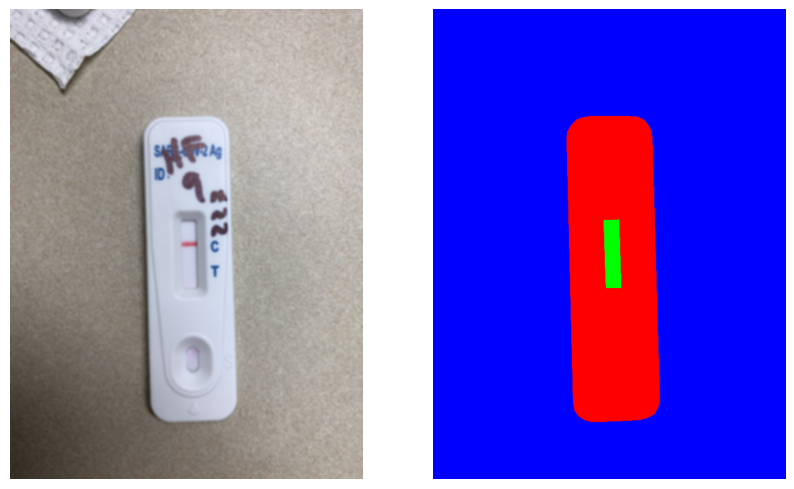

In [ ]:
blur = A.Blur(blur_limit=transformation_args.blur_limit, p=1.0)
transformation_dict = blur(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Color jitter

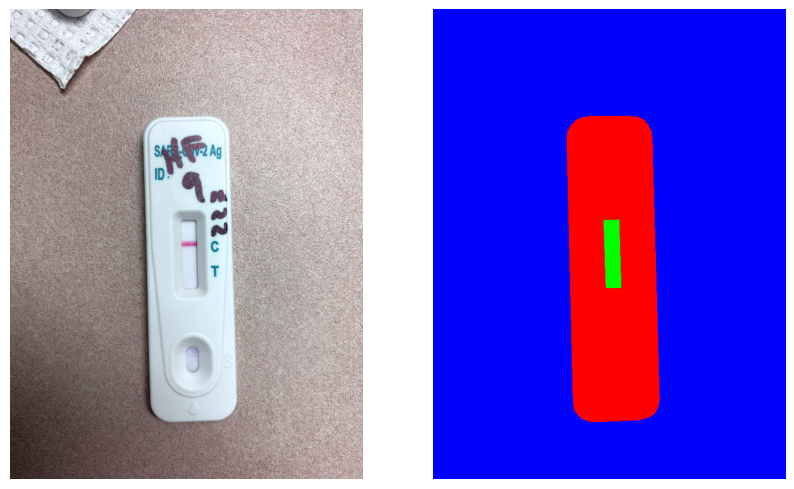

In [ ]:
color_jitter = A.ColorJitter(brightness=transformation_args.color_jitter_brightness,
                             contrast=transformation_args.color_jitter_contrast,
                             saturation=transformation_args.color_jitter_saturation,
                             p=1.0)
transformation_dict = color_jitter(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

##### Affine

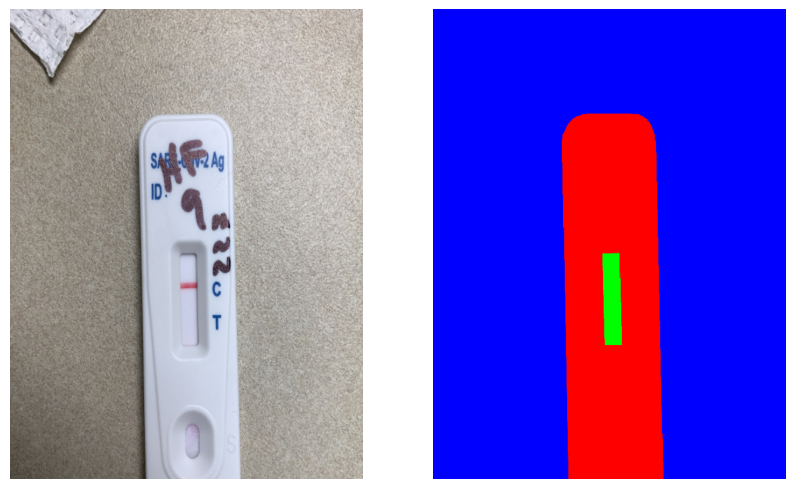

In [ ]:
affine = A.Affine(scale=transformation_args.affine_scale,
                  translate_percent=transformation_args.affine_translate_percent, p=1)
transformation_dict = affine(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Downscale

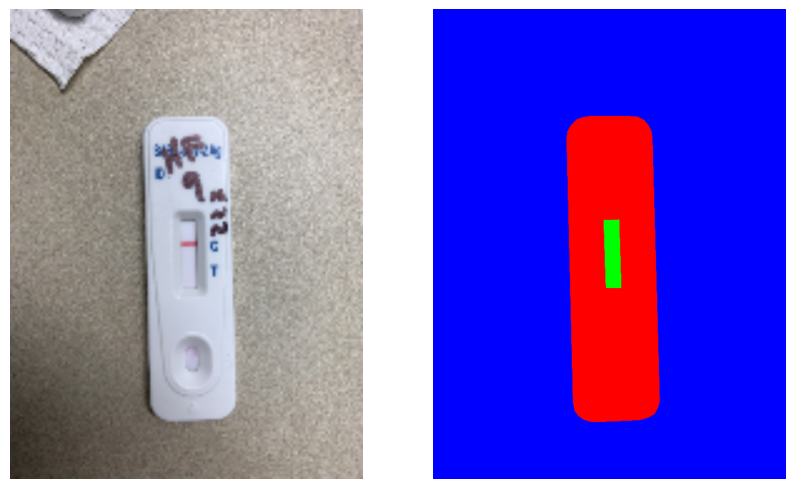

In [ ]:
dowscale = A.Downscale(scale_min=transformation_args.downscale_min,
                       scale_max=transformation_args.downscale_max,
                       interpolation=cv2.INTER_LINEAR, p=1)
transformation_dict = dowscale(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Gaussnoise

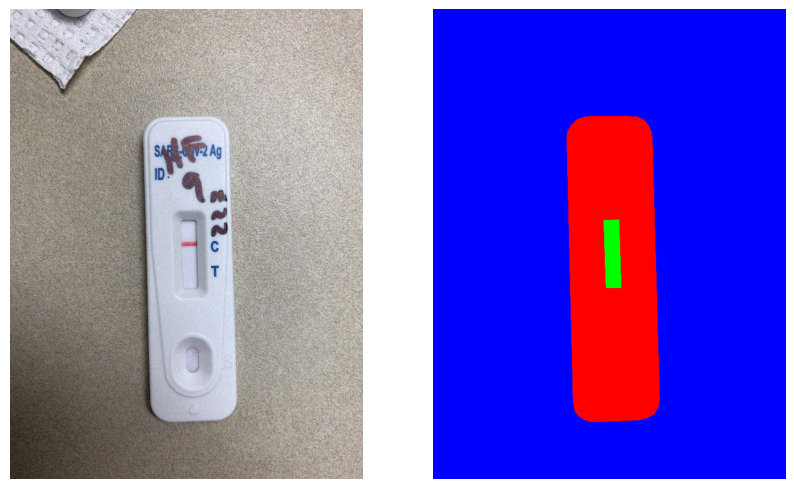

In [ ]:
gauss_noise = A.GaussNoise(var_limit=transformation_args.gauss_noise_var_limit, p=1)
transformation_dict = gauss_noise(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Perspective

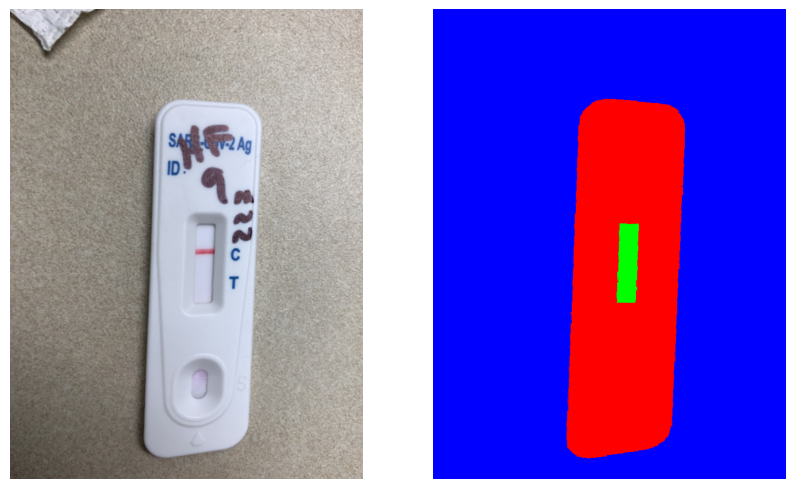

In [ ]:
perspective = A.Perspective(scale=transformation_args.perspective_scale, p=1)
transformation_dict = perspective(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

#### Altogether

We combined all these transformations in a `TransformationSegmentationTraining` class. The transformation parameters are pre-determined and can be read from the configuration file.

In [ ]:
from transformations_seg import TransformationSegmentationTraining

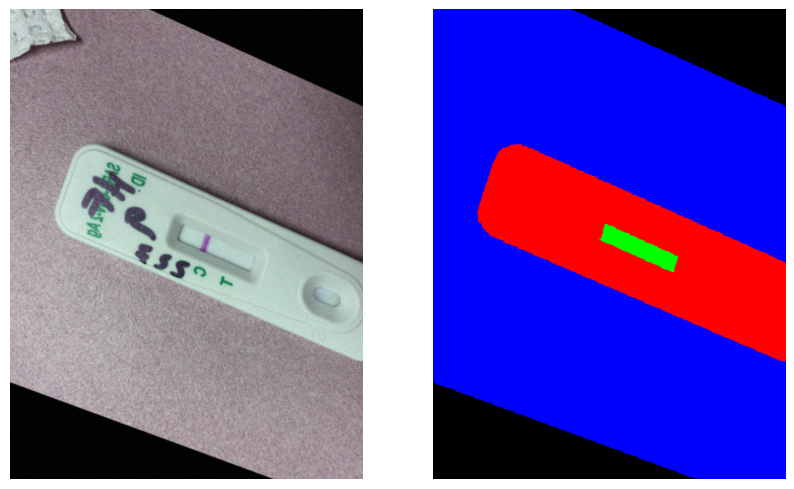

In [ ]:
compose_transformation = TransformationSegmentationTraining(transformation_args)
image_t, mask_t = compose_transformation(image, mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t[:,:,::-1])
ax1.axis('off')
ax2.imshow(mask_t[:,:,::-1])
ax2.axis('off')
plt.show()

### Final form of dataset + dataloader + transformations

In [ ]:
# Create dataset and dataloader
kit_id = 'aconag'

transformation_train = TransformationSegmentationTraining(transformation_args)

loader_train = init_dataloader(data_args, kit_id, 'train',
                               n_batches=4, n_workers=0, shots=10, shuffle=True, transform=transformation_train)

# Read batch
batch = next(iter(loader_train))
images, targets = batch[0], batch[1]

# Display batch
show_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

## References

* [Video-tutorial on how to use augmentation for segmentation](https://www.youtube.com/watch?v=rAdLwKJBvPM&t=556s)